Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Geographical and Spatial Analysis

Information on the Python Packages used:  
https://github.com/bear/python-twitter (before was http://code.google.com/p/python-twitter/)  
https://dev.twitter.com/docs  
http://networkx.lanl.gov/  
http://docs.python.org/library/re.html  
http://nltk.org/  
http://docs.python.org/library/xmlrpclib.html  
http://docs.python.org/library/webbrowser.html  
http://docs.python.org/library/codecs.html  
http://matplotlib.sourceforge.net/  
http://numpy.scipy.org/  
http://docs.python.org/library/itertools.html  
http://docs.python.org/library/sys.html  
http://docs.python.org/library/json.html  
http://docs.python.org/library/os  
https://pypi.python.org/pypi/basemap/1.0.7  
http://matplotlib.org/basemap/  
http://matplotlib.org/basemap/users/installing.html  
https://pypi.python.org/pypi/geopy  

In [4]:
from __future__ import division
import twitter
import nltk
import re
import networkx as nx
import sys
import os
import json
from itertools import chain
import urllib
from datetime import datetime
from datetime import timedelta
import webbrowser
import codecs
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopy.geocoders as gg
from nominatim import Nominatim
import Levenshtein
from bs4 import BeautifulSoup
from IPython.display import Image, HTML, IFrame, FileLink, FileLinks #needed to render in notebook
from IPython.core.display import display
#import pydot  #Install http://www.graphviz.org/ & https://pypi.python.org/pypi/pydot2/1.0.32 pydot --> pip install pydot2

%matplotlib inline
# Set default figure size for this notebook
plt.rcParams['figure.figsize'] = (16.0, 12.8)

/usr/local/lib/python3.5/dist-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/usr/local/lib/python3.5/dist-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/usr/local/lib/python3.5/dist-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/usr/local/lib/python3.5/dist-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag()

#### Specifying the path to the files

In [4]:
templates = "../templates/"
outputs = "../outputs/"

dotfile = "graph_retweet.dot"
pngfile = "graph_retweet.png"
protofile = "graph_retweet.html"
tweetsfile = "Tweets_dump.txt"
template_proto = 'template_protoviz.html'

pathdotfile = os.path.join(outputs,dotfile)
pathpngfile = os.path.join(outputs,pngfile)
pathprotofile = os.path.join(outputs,protofile)
pathtweetsfile = os.path.join(outputs,tweetsfile)
pathtemplate = os.path.join(templates,template_proto)

stoplist_en = nltk.corpus.stopwords.words('english')
stoplist_pt = nltk.corpus.stopwords.words('portuguese')
ignorewords = stoplist_en + stoplist_pt + ['',' ','-','rt']

twitter_query = u'Earth'

### Using geographical resources within Python

In [5]:
gg.OpenMapQuest()
geolocator = gg.GoogleV3()

To geolocate a query to an address and coordinates:

In [6]:
logradouro = "Dona Mariana, Botafoga" #Note that there is a typo in the name "Botafogo"
address, (latitude, longitude) = geolocator.geocode(logradouro)
print(address)
print(latitude, longitude)

Rua Dona Mariana - Botafogo, Rio de Janeiro - RJ, Brazil
-22.9529422 -43.1886221


In [7]:
#Measuring editing distances between names:
Levenshtein.ratio('Dona Mariana, Botafoga', 'Rua Dona Mariana - Botafogo')

0.8163265306122449

In [8]:
#https://developers.google.com/maps/documentation/staticmaps/
#http://stackoverflow.com/questions/2660201/what-parameters-should-i-use-in-a-google-maps-url-to-go-to-a-lat-lon/9919251#9919251
#m – normal map k – satellite h – hybrid p – terrain

def gmap(address,lat,lon,zoom=15,tmap='m'):
    # Google Maps URL template for an iframe
    google_maps_url = 'http://maps.google.com/maps?q={0}&loc:{1}+{2}&z={3}&t={4}&output=embed'.format(address,
                                                                                                     lat,
                                                                                                     lon,
                                                                                                     zoom,
                                                                                                     tmap,)
    display(IFrame(google_maps_url, '800px', '600px'))
    
gmap(address, latitude, longitude,17,'k')

To find the address corresponding to a set of coordinates:

In [9]:
addresses = geolocator.reverse("46.649,6.383")
for address in addresses:
    print(address)

Fauchy, 1148 Mont-la-Ville, Switzerland
1148 Mont-la-Ville, Switzerland
1148 Moiry, Switzerland
Morges District, Switzerland
Vaud, Switzerland
Switzerland


### Using Python and QGIS for geospatial visualizations - a Case Study  
https://www.airpair.com/python/posts/using-python-and-qgis-for-geospatial-visualization  

In [10]:
base_url = "http://www.nuforc.org/webreports/"
index_url = "http://www.nuforc.org/webreports/ndxevent.html"

In [34]:
def can_cast_as_dt(dateStr, fmt):
    try:
        datetime.strptime(dateStr, fmt)
        return True
    except ValueError:
        return False

def parse_dt(dateStr):
    # the data in the website comes in two different formats, try both 
    for fmt in ["%m/%d/%y %H:%M", "%m/%d/%y"]:
        try:
            return datetime.strptime(dateStr, fmt)
        except ValueError:
            continue

def get_data_from_url(url):
    print("Processing {}".format(url))
    data = []
    source = BeautifulSoup(urllib.request.urlopen(url), "html5lib")
    for row in source('tr'):
        if not row('td'):
            continue # header row
        row_data = row('td')
        # parse the datetime from the string
        date_time = parse_dt(row_data[0].text)
        city = row_data[1].text
        state = row_data[2].text
        shape = row_data[3].text
        duration = row_data[4].text
        data.append((date_time, city, state, shape, duration))
    return data

In [82]:
# get the index page
raw_page = urllib.request.urlopen(index_url)
source = BeautifulSoup(raw_page, "html5lib")
# get all the links in the index page
func1 = lambda x: (x.text, base_url + x['href'])
monthly_urls = list(map(func1,source('a')))
# get  the last 12 links that have a text like 06/2015
func2 = lambda x: can_cast_as_dt(x[0], "%m/%Y")
last_year_urls = filter(func2, monthly_urls[0:13]) 
# extract the data from each monthly page and flatten the lists of tuples
last_year_ufos = list(chain(*map(lambda x: get_data_from_url(x[1]), last_year_urls)))
# initialize a pandas DataFrame with the list of tuples

Processing http://www.nuforc.org/webreports/ndxe201608.html
Processing http://www.nuforc.org/webreports/ndxe201607.html
Processing http://www.nuforc.org/webreports/ndxe201606.html
Processing http://www.nuforc.org/webreports/ndxe201605.html
Processing http://www.nuforc.org/webreports/ndxe201604.html
Processing http://www.nuforc.org/webreports/ndxe201603.html
Processing http://www.nuforc.org/webreports/ndxe201602.html
Processing http://www.nuforc.org/webreports/ndxe201601.html
Processing http://www.nuforc.org/webreports/ndxe201512.html
Processing http://www.nuforc.org/webreports/ndxe201511.html
Processing http://www.nuforc.org/webreports/ndxe201510.html
Processing http://www.nuforc.org/webreports/ndxe201509.html


In [135]:
ufos_df = pd.DataFrame(last_year_ufos, columns=["start","city","state","shape","duration_description"])
ufos_df[0:10]

,start,city,state,shape,duration_description
0,2016-08-29 04:00:00,Hermitage,TN,Unknown,2 hours
1,2016-08-29 00:20:00,New York City (Bronx),NY,Unknown,1 hour
2,2016-08-28 21:40:00,Juneau,AK,Formation,25 seconds
3,2016-08-28 21:35:00,Runnemede,NJ,,1 minute
4,2016-08-28 20:45:00,Williamsburg,VA,Unknown,20 minutes
5,2016-08-28 19:50:00,Santa Rosa,CA,Light,15 minutes
6,2016-08-28 19:30:00,Santa Rosa,CA,Oval,1 hour
7,2016-08-28 09:30:00,Northampton (UK/England),,Oval,15 seconds
8,2016-08-28 09:00:00,Camden,NY,Other,10 minutes
9,2016-08-28 08:57:00,Old Lyme,CT,Cross,1 minute


In [138]:
ufos_df.replace(to_replace='', value=np.nan, inplace=True, limit=None, regex=False, method='pad', axis=None)
ufos_df = ufos_df.dropna() 
ufos_df.head(18)

,start,city,state,shape,duration_description,duration_secs
0,2016-08-29 04:00:00,Hermitage,TN,Unknown,2 hours,7200.0
1,2016-08-29 00:20:00,New York City (Bronx),NY,Unknown,1 hour,3600.0
2,2016-08-28 21:40:00,Juneau,AK,Formation,25 seconds,25.0
4,2016-08-28 20:45:00,Williamsburg,VA,Unknown,20 minutes,1200.0
5,2016-08-28 19:50:00,Santa Rosa,CA,Light,15 minutes,900.0
6,2016-08-28 19:30:00,Santa Rosa,CA,Oval,1 hour,3600.0
8,2016-08-28 09:00:00,Camden,NY,Other,10 minutes,600.0
9,2016-08-28 08:57:00,Old Lyme,CT,Cross,1 minute,60.0
10,2016-08-27 23:15:00,White House,TN,Fireball,5 minutes,300.0
11,2016-08-27 22:45:00,Detroit,MI,Formation,5-10 minutes,600.0


In [146]:
# function that infers the duration from the text 
def infer_duration_in_seconds(text):
    # try different regexps to extract the total seconds
    metric_text = ["second","s","Second","segundo","minute","m","min","Minute","hour","h","Hour"]
    metric_seconds = [1,1,1,1,60,60,60,3600,3600,3600]
    for metric,mult in zip(metric_text, metric_seconds):
        regex = "\s*(\d+)\+?\s*{}s?".format(metric)
        text = text.replace('<','')
        text = text.replace('>','')
        #text = text[0:text.find('(')]
        res = re.findall(regex,text)
        if len(res)>0:
            return int(float(res[0]) * mult)
    return None

# extract the duration in seconds
ufos_df["duration_secs"] = ufos_df["duration_description"].apply(infer_duration_in_seconds)
# now we can infer the end time of the UFO sighting as well
# which will be useful for the animation later
ufos_df["end"] = ufos_df.apply(lambda x:x["start"] + timedelta(seconds=x["duration_secs"]),axis=1)
ufos_df = ufos_df.dropna()
ufos_df[0:10]

,start,city,state,shape,duration_description,duration_secs,end
0,2016-08-29 04:00:00,Hermitage,TN,Unknown,2 hours,7200,2016-08-29 06:00:00
1,2016-08-29 00:20:00,New York City (Bronx),NY,Unknown,1 hour,3600,2016-08-29 01:20:00
2,2016-08-28 21:40:00,Juneau,AK,Formation,25 seconds,25,2016-08-28 21:40:25
4,2016-08-28 20:45:00,Williamsburg,VA,Unknown,20 minutes,1200,2016-08-28 21:05:00
5,2016-08-28 19:50:00,Santa Rosa,CA,Light,15 minutes,900,2016-08-28 20:05:00
6,2016-08-28 19:30:00,Santa Rosa,CA,Oval,1 hour,3600,2016-08-28 20:30:00
8,2016-08-28 09:00:00,Camden,NY,Other,10 minutes,600,2016-08-28 09:10:00
9,2016-08-28 08:57:00,Old Lyme,CT,Cross,1 minute,60,2016-08-28 08:58:00
10,2016-08-27 23:15:00,White House,TN,Fireball,5 minutes,300,2016-08-27 23:20:00
11,2016-08-27 22:45:00,Detroit,MI,Formation,5-10 minutes,600,2016-08-27 22:55:00


In [148]:
geolocator = Nominatim()
ufos_df["lat"] = ufos_df.apply(lambda x:geolocator.query(x['city'])[0]['lat'],axis=1)
#geolocator.query("Houston, TX")
ufos_df[0:10]

IndexError: ('list index out of range', 'occurred at index 51')

In [151]:
geolocator.query('Kansas City/Columbia (between)')

[]

In [150]:
ufos_df[48:52]

,start,city,state,shape,duration_description,duration_secs,end
60,2016-08-23 21:30:00,East Providence,RI,Light,2 minutes,120,2016-08-23 21:32:00
61,2016-08-23 21:00:00,Palm Harbor,FL,Light,10-12 minutes,720,2016-08-23 21:12:00
63,2016-08-23 17:30:00,Kansas City/Columbia (between),MO,Triangle,10 minutes (flyover),600,2016-08-23 17:40:00
66,2016-08-22 22:30:00,Ann Arbor,MI,Light,5 minutes,300,2016-08-22 22:35:00


In [149]:
# Note: dropna will drop any columns with None values, which is desirable
ufos_df[["start","end","lon","lat","shape"]].dropna().to_csv("ufo_data.csv",index=False, encoding="utf-8")

KeyError: "['lon' 'lat'] not in index"

### Using geographical resources for twitter Analysis

Twitter API Keys  
Please generate yours...  
Go to http://twitter.com/apps/new to create an app and get these items  
See https://dev.twitter.com/docs/auth/oauth for more information on Twitter's OAuth implementation  
https://dev.twitter.com/rest/reference/get/account/verify_credentials  
https://dev.twitter.com/docs/auth/oauth  
https://dev.twitter.com/apps/new  

In [152]:
with open('twitter_tokens.txt', 'r') as twitter_tokens:
    tokens = twitter_tokens.read().split(',')
consumer_key = tokens[0].strip()
consumer_secret = tokens[1].strip()
access_token = tokens[2].strip()
access_token_secret = tokens[3].strip()

Acessing Twitter (with or without authentication)

In [153]:
#api = twitter.Api() # Accessing with no authentication
api = twitter.Api(consumer_key, consumer_secret, access_token, access_token_secret)

In [154]:
print(api.VerifyCredentials())

{"created_at": "Thu Apr 09 10:44:07 +0000 2009", "description": "Researcher and Professor", "favourites_count": 1, "followers_count": 494, "friends_count": 133, "id": 29959702, "lang": "en", "listed_count": 19, "location": "Rio de Janeiro", "name": "Renato Rocha Souza", "profile_background_color": "9AE4E8", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/33941499/8.jpg", "profile_image_url": "http://pbs.twimg.com/profile_images/503088023/Renato2_normal.JPG", "profile_link_color": "0084B4", "profile_sidebar_fill_color": "DDFFCC", "profile_text_color": "333333", "screen_name": "rrsouza", "status": {"created_at": "Mon Jan 05 11:05:11 +0000 2015", "hashtags": [{"text": "FGV"}, {"text": "emap"}], "id": 552058220781797376, "id_str": "552058220781797376", "lang": "und", "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>", "text": "http://t.co/5l4lGVKiBG #FGV #emap", "urls": [{"expanded_url": "http://blog.udacity.com/2014/11/data-s

#### Lexical Analysis

Recent (random) public messages

In [155]:
msgpublicas = api.GetStreamSample()

In [156]:
for i in range(15):
    tweet = next(msgpublicas)
    if 'text' in tweet:
        print(u'{}\n'.format(tweet['text']))

@dora_potisuke @rits1091 @kurodai147 みんなトレーニングして恐ろしい...w

riak

@TheHazelHayes halfway through it and you just said you were supporting Portugal and not France during #eurofinals . Tears. Sadness.

RT @grabesila: Aanhin mo ang malaking KAMA.
Kung ang asawa, nasa IBA.
#ALDUBLessonsOfLOVE

RT @ViolettaSpain19: @xsmileofjortini Jajjajajajajaa, siii. Quería hacer limpieza, pero me niego a borrar nada de lo que tengo en ella jaja…

IF YOU WERE DEAD OR STILL ALIVE, I DON'T CARE, I DON'T CARE. JUST GO AND LEAVE THIS ALL BEHIND, CAUSE I SWEAR, I DON'T CARE.

RT @WhoadieBrees: Chris Brown baby monma set him up lmaoooo he just won custody of their child and she just so happen to be friends with th…

RT @jamiechung1: I've spent the day with the fabulous team from petfinder to help spread the word! If you're… https://t.co/9BdNCM3ief

@missyxclark red

@MatthewDaddario @aitanadpv no seven

@ProjetoDMeFT SDV

RT @munira14003: #عطاله_خريجي_علم_النفس_و_الاجتماع

 #التعليم_يتجاهل_توظيف_الخريجات
بالرغم 

Tweet Structure

In [157]:
while True:
    tweet = next(msgpublicas)
    if 'user' in tweet:
        break
tweet

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Aug 30 21:32:21 +0000 2016',
 'entities': {'hashtags': [],
  'media': [{'display_url': 'pic.twitter.com/7MM7NIOFgQ',
    'expanded_url': 'https://twitter.com/AhmedZubaidy/status/770571732591804416/photo/1',
    'id': 770571712362524672,
    'id_str': '770571712362524672',
    'indices': [139, 140],
    'media_url': 'http://pbs.twimg.com/media/CrGe48VVMAARiao.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CrGe48VVMAARiao.jpg',
    'sizes': {'large': {'h': 802, 'resize': 'fit', 'w': 600},
     'medium': {'h': 802, 'resize': 'fit', 'w': 600},
     'small': {'h': 680, 'resize': 'fit', 'w': 509},
     'thumb': {'h': 150, 'resize': 'crop', 'w': 150}},
    'source_status_id': 770571732591804416,
    'source_status_id_str': '770571732591804416',
    'source_user_id': 1533230778,
    'source_user_id_str': '1533230778',
    'type': 'photo',
    'url': 'https://t.co/7MM7NIOFgQ'}],
  'symbols': [],
  'urls': [],
  'user_me

In [158]:
Image(url='http://mike.teczno.com/img/raffi-krikorian-map-of-a-tweet.png')

Recent messages from an user

In [159]:
msguser = api.GetUserTimeline(tweet['user']['id'])
print([s.text for s in msguser])

['RT @AhmedZubaidy: @TelmaZamariolli @houda_meme @diaastar15 @LuluAhb @bosyzezo1 @manal2015only @47Far @55Hsa @AlgadaffiDania @m7arah1 https:…', 'RT @7PqjsD1ILDsGuir: كل الحاجات الميته ف داخلك استبدلها بناس\nحيه تعيّشك لون الصبح وهدوء الليل لاتدفن نفسك مع أشياء ميته وإنت مليان حياة htt…', 'RT @liboolibyanagm1: لو بعد مائة عاااااام ،، ما يتكرّر ..\nإيجى في العروبة صقر ،، كيف معمر ..\nالجماهير تحتفل (( 47 )) !!! . https://t.co/E0I…', 'RT @mona_kh11: عطرو افواهكم ..\nبالصﻻة على الحبيب المصطفى صلى الله عليه وسلم ... https://t.co/74NwzYWdhV', 'RT @mansuor168: اللهم كما تحي الأرض بماءك .. \nأحي قلوبنا بذكرك و ثنائك و شكر نعماؤك. واغفر ذنوبنا، \nو اقبل دعائنا، \nو وفقنا لما تحب https:/…', 'RT @Kanz_Alkwfel77: تقضي الأغنام عمرها خائفه من الذئب\nفي حين أن من يأكلها في النهاية هو الراعي .. https://t.co/eIujsMALRo', 'RT @melbardisi1: @helallah @kayal40 @zouhourmalti1 @Gabriella_sabah @SoonaMaatouk @daadsabeh @Anwaroosh01 https://t.co/IIp1vmWQ9q', 'RT @melbardisi1: https://t.co/NjPS8RXcg3', 'RT @m

Recent messages from the authenticated user

In [160]:
msguser = api.GetUserTimeline('rrsouza')
#msguser = api.GetUserTimeline('29959702')
print([s.text for s in msguser])

['http://t.co/5l4lGVKiBG #FGV #emap', 'Olá Pessoal! Fiquem atentos à aula de Modelagem e Mineração de Dados... Hoje análises com Twitter!', 'Mais um curioso fenômeno dos nossos tempos: #LeakForJLaw Or maybe #LeakForPerverts ?', 'RT @mashable: 8 Brutally Honest Facebook Notifications That Need to Exist Now http://t.co/wwFQ1hut9x http://t.co/b2GjxcNb6D', '#Cite10CoisasQueSuaMãeFala come alguma coisa antes para não chegar na festa esfomeado', 'Implicações do Big Data para as questões de privacidade: http://t.co/WDJwxpOr9d', 'Resultados da seleção do Mestrado em Modelagem Matemática da Informação - turma 2013 saem nesta sexta, 08/02. #FGV #EMAp', 'RT @PyPLN: We just released the very first version (0.1.0) of pypln.api -- a Python library to programatically access @PyPLN Web! http:/ ...', "Men's Fitness UK by Dennis Publishing Ltd http://t.co/y8YZBBeP", "I'm at Capes (Brasília, DF) w/ 2 others http://t.co/QiukVJqW", "I'm at Capes (Brasília, DF) http://t.co/OfRoPS0y", '@israelst na verdade, 

In [161]:
hometimeline = api.GetHomeTimeline()
print([u.GetText() for u in hometimeline])

AttributeError: 'Status' object has no attribute 'GetText'

In [162]:
search = api.GetSearch(twitter_query)
print([s.text for s in search])

NameError: name 'twitter_query' is not defined

After authentication, more options are available

In [163]:
userfollow = api.GetFriends()
print([u.name for u in userfollow])

['Lucas Parisi', 'Carla Codeço Coelho', 'Overleaf', 'Cláudio Berrondo', 'Flávio Amieiro', 'Pablo Cerdeira', 'Cut the Rope', 'Machinalis', 'MiningTheSocialWeb', 'CNET News', 'ReadWrite', 'The Next Web 🌍💻📱', 'CNET', 'The Verge', 'Engadget', 'Lifehacker', 'Gizmodo', 'WIRED', 'TechCrunch', 'Ian Ozsvald', 'CNPq', 'Claudio Gnoli', 'strongsteam', 'Diana Maynard', 'Joyce Figueiró', 'Álvaro Justen', 'PyPLN', 'Open Source For You', 'TechRepublic', 'ZDNet', 'Twitter API', 'Udacity', 'Clarissa', 'Roberto R.S.Sobrinho', 'Luana Sales', 'Sensacionalista', 'André Branco', 'CMA', 'Asla Sá', 'Renata Teixeira', 'FGV EMAp', 'FGV', 'FGV Marketing', 'CPDOC', 'Globant Brasil', 'Sheffield NLP', 'Débora Pereira', 'André Andrade', "O'Reilly Radar", 'Virgilio Almeida', 'Dalai Lama', 'Alexandre Colucci', 'Benildes Maculan', 'Gabriel Rezende', 'Mashable', 'alfredo hirsch', 'Fernando S Parreiras', 'NYTimes Bits', 'MiniCursos', 'Googleverse', 'Hootsuite', 'G1 - Concursos', 'Ivana', 'Dina Araujo', 'João Batista', 'W3

In [164]:
def lexical_diversity(text):
    return len(text) / len(set(text))

Searching for a term in tweets

In [165]:
def search_for_term(termo, pages, results):
    '''Search and return tweets on a subject (5 pages of 100 results each)
    Save results in a file defined in "pathtweetsfile" '''
    search_results = []
    tweets = []
    tweets_txt = []
    tweets_words = []
    names = []
    last = api.GetSearch(term=termo, count=1)
    search_results.append(last)
    list_ids = []
    list_ids.append(last[0].GetId())
    for i in range(pages):
        id_last = last[0].GetId()
        new_tweets = api.GetSearch(term=termo, count=results, max_id=min(list_ids))
        for i in range(len(new_tweets)):
            list_ids.append(new_tweets[i].GetId())
        search_results.append(new_tweets)
    for i in range(len(search_results)):
        for j in range(len(search_results[i])):
            tweets.append(search_results[i][j])
    tweets_txt += [tweet.text.split(u' ') for tweet in tweets]
    for i in range(len(tweets)):
        tweets_words += [word.lower().strip(u':@&$!?') for word in tweets_txt[i]]
    for i in range(len(tweets)): 
        names += [word.strip(u':@&$!?') for word in tweets_txt[i] if word.istitle() and len(word) > 2]
    out = file(pathtweetsfile,'w')
    for tweet in tweets_txt: 
        out.write(u'\n{}'.format(tweet))
    return tweets, tweets_txt, tweets_words, names

Using our customized function that retrieves 5 x 100 tweets

In [166]:
tweets, tweets_txt, tweets_words, names = search_for_term(twitter_query,5,10)
    
print('Word count: {}'.format(len(tweets_words)))
print('Repertoire: {}'.format(len(set(tweets_words))))
print('Lexical diversity: {}'.format(lexical_diversity(tweets_words)))

NameError: name 'twitter_query' is not defined

In [54]:
freq_dist = nltk.FreqDist(tweets_words)
freq_dist.plot(40)
freq_dist.plot(40, cumulative = True)

NameError: name 'tweets_words' is not defined

In [55]:
print('10 most frequent words')
print(freq_dist.keys()[:10])

10 most frequent words


NameError: name 'freq_dist' is not defined

In [56]:
print('10 less frequent words')
print(freq_dist.keys()[-10:])

10 less frequent words


NameError: name 'freq_dist' is not defined

In [57]:
print('Sorted list of words')
print(sorted(set(tweets_words)))

Sorted list of words


NameError: name 'tweets_words' is not defined

Same as before, without stopwords. See variable "ignorewords"

In [58]:
new_tweets_words = [word for word in tweets_words if word not in ignorewords]
    
freq_new = nltk.FreqDist(new_tweets_words)    
freq_new.plot(50)

NameError: name 'tweets_words' is not defined

In [59]:
freq_new.plot(50, cumulative = True)

NameError: name 'freq_new' is not defined

In [60]:
print('10 most frequent words')
print(freq_new.keys()[:10])

10 most frequent words


NameError: name 'freq_new' is not defined

In [61]:
print('10 less frequent words')
print(freq_new.keys()[-10:])

10 less frequent words


NameError: name 'freq_new' is not defined

In [62]:
print('Sorted list of words')
print(sorted(set(new_tweets_words)))

Sorted list of words


NameError: name 'new_tweets_words' is not defined

Counting specific words

In [106]:
print(new_tweets_words.count(u'prova'))
print(freq_new[u'gabarito']) #same as before
print(freq_new.freq(u'cola')) #relative to the others

0
0
0.0


Eliminating small words or words with specific sizes

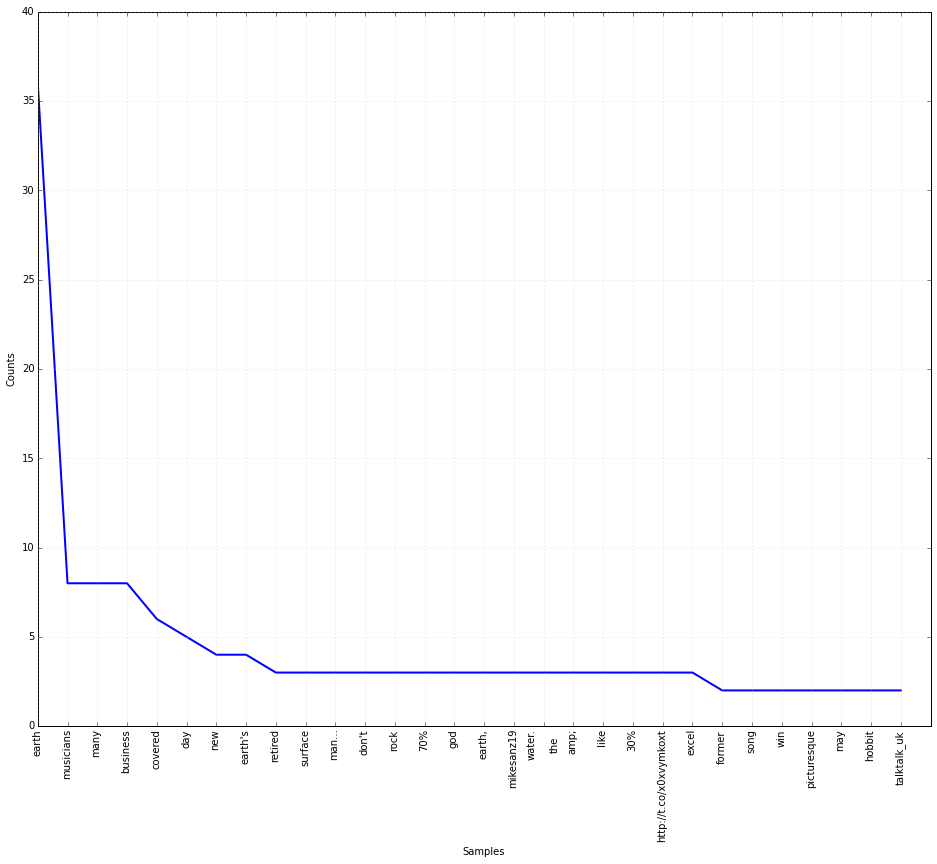

In [107]:
bigger_tweets_words = [word for word in new_tweets_words if len(word) > 2]
#mediumsized_tweets_words = [word for word in new_tweets_words if len(word) > 2 and len(word) < 9]
freq_bigger = nltk.FreqDist(bigger_tweets_words)    
freq_bigger.plot(30)

Citation Analysis

In [108]:
citacoes = [word for word in tweets_words if '@' in word]
#citacoes = [word for word in tweets_words if word.startswith('@')]
freq_citacoes = nltk.FreqDist(citacoes)
freq_citacoes.items()

[]

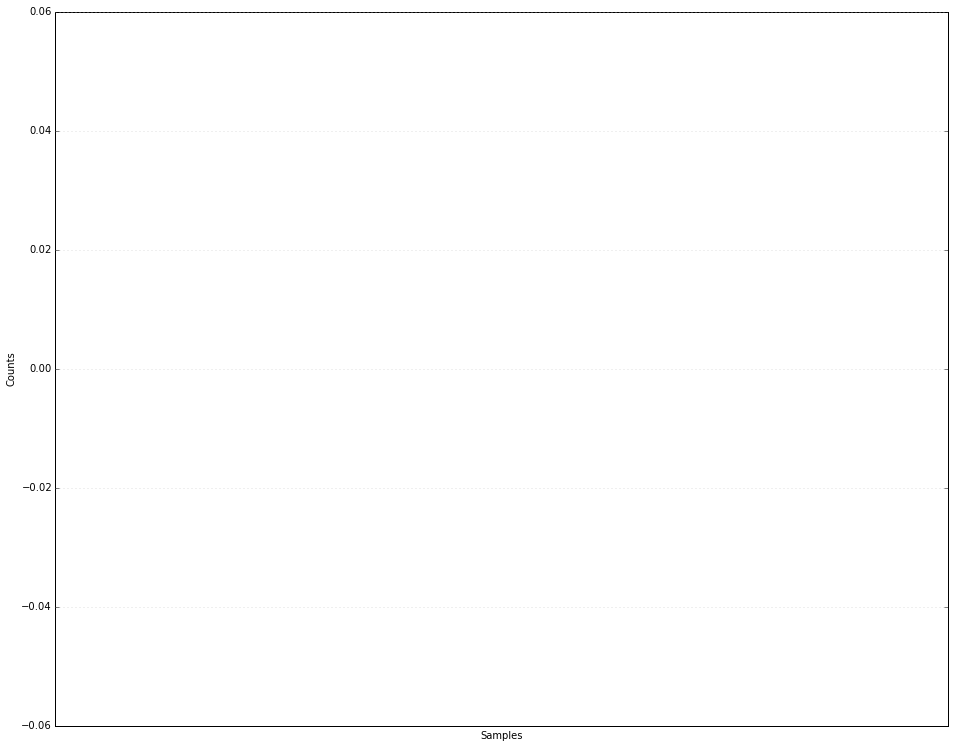

In [109]:
freq_citacoes.plot()

Hashtag Analysis

In [110]:
hashtags = [word for word in tweets_words if word.startswith('#')]
freq_hashtags = nltk.FreqDist(hashtags)
freq_hashtags.items()

[(u'#mobilemarketing', 1),
 (u'#prayer', 1),
 (u'#climatechange', 1),
 (u'#earth', 1),
 (u'#planet', 1),
 (u'#happybirthdayluis', 1),
 (u'#globalwarming', 1),
 (u'#tanyatucker', 1),
 (u'#bethechange', 1),
 (u'#environment', 1),
 (u'#isf', 1),
 (u'#msg9successfulweeks', 1),
 (u'#didgeridoo', 1),
 (u'#deltadawn', 1)]

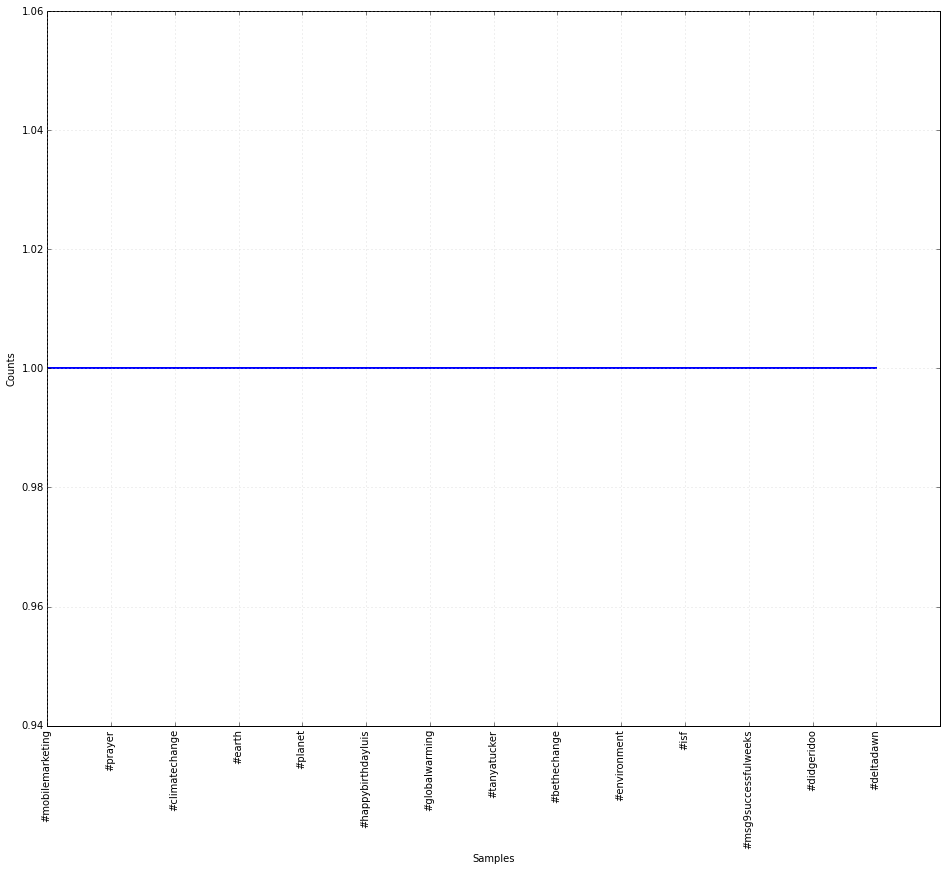

In [111]:
freq_hashtags.plot()

Analysis of Frequent words  
Can be used with any of the previous lists'''

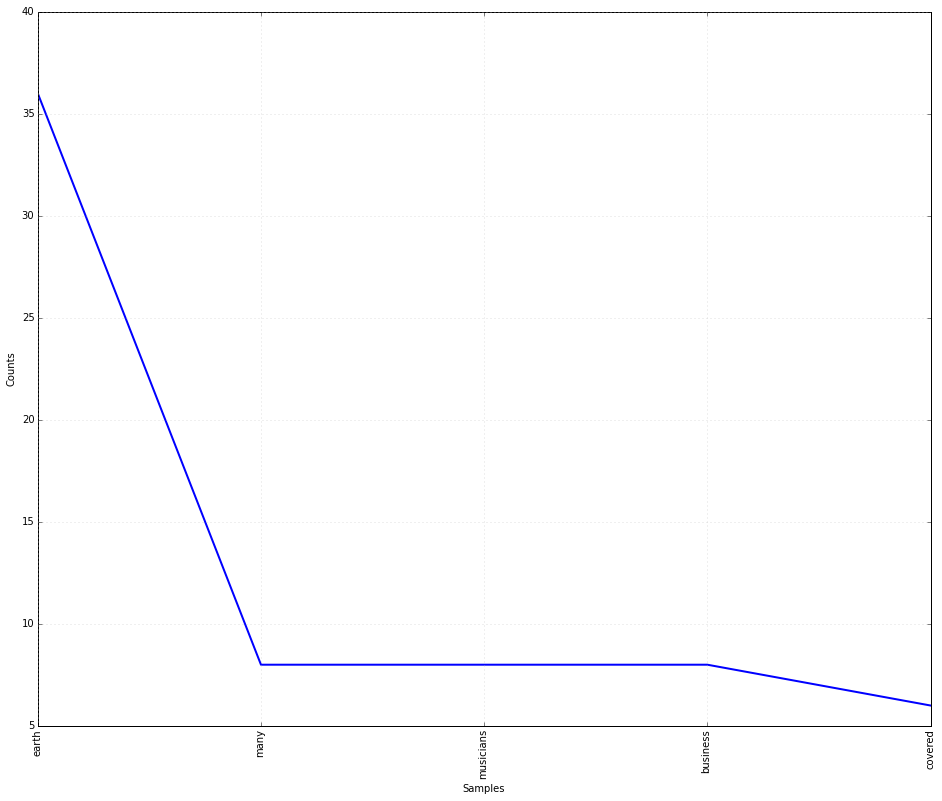

In [112]:
frequent_words = [word.lower() for word in new_tweets_words if tweets_words.count(word) > 5]
freq_dist2 = nltk.FreqDist(frequent_words)
freq_dist2.plot(40)

Words Sizes

In [113]:
freq_size_words = nltk.FreqDist([len(w) for w in new_tweets_words])
freq_size_words.items()

[(1, 5),
 (2, 20),
 (3, 52),
 (4, 82),
 (5, 91),
 (6, 56),
 (7, 41),
 (8, 33),
 (9, 23),
 (10, 11),
 (11, 16),
 (12, 9),
 (13, 6),
 (14, 7),
 (15, 2),
 (16, 1),
 (18, 1),
 (20, 1),
 (22, 29),
 (23, 3),
 (24, 2),
 (28, 1),
 (33, 1),
 (61, 1),
 (66, 1)]

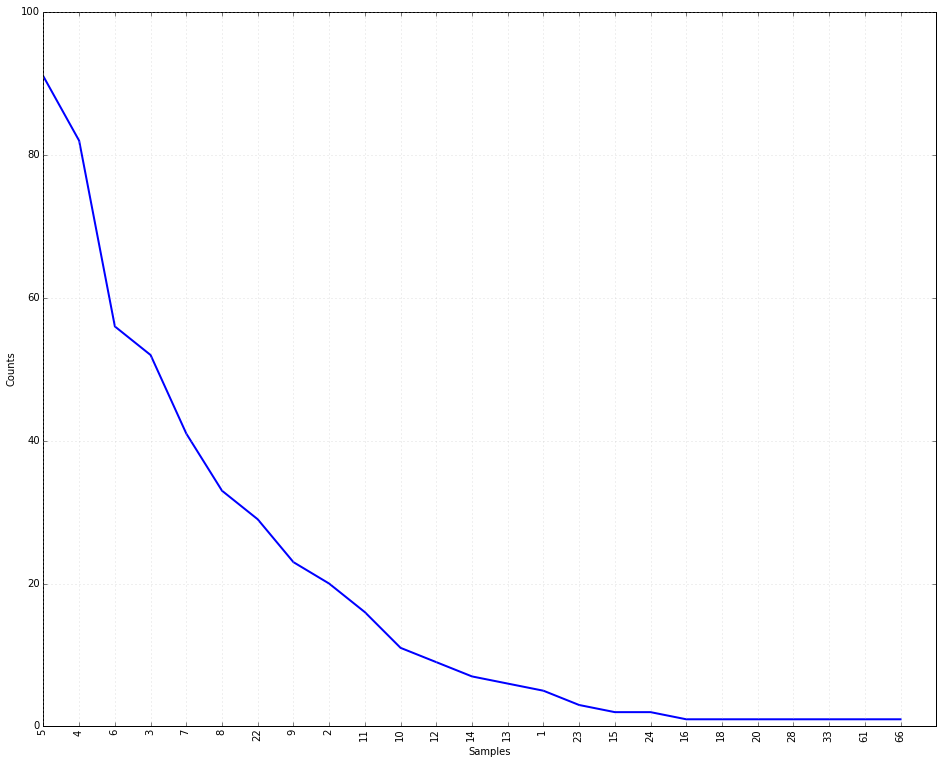

In [114]:
freq_size_words.plot()

Bigrams

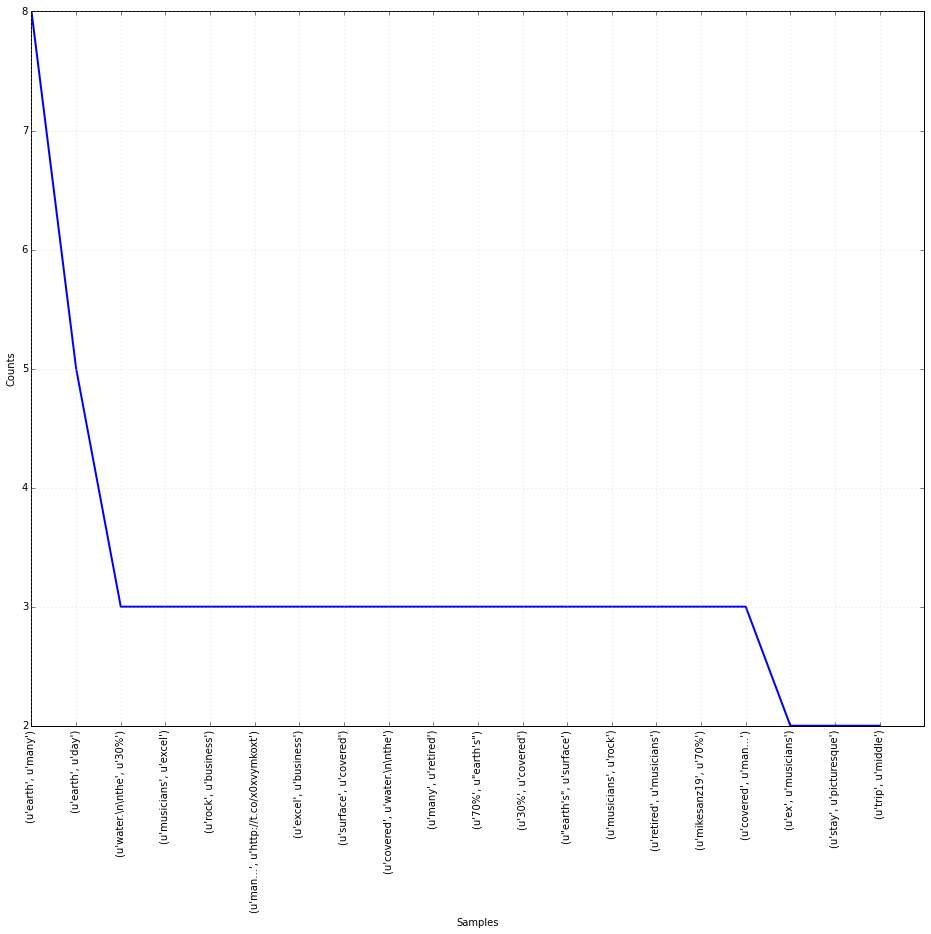

In [115]:
bigramas_tweets = nltk.bigrams(new_tweets_words)
freqbig = nltk.FreqDist(bigramas_tweets)
freqbig.plot(20)

Names (capitalized words)

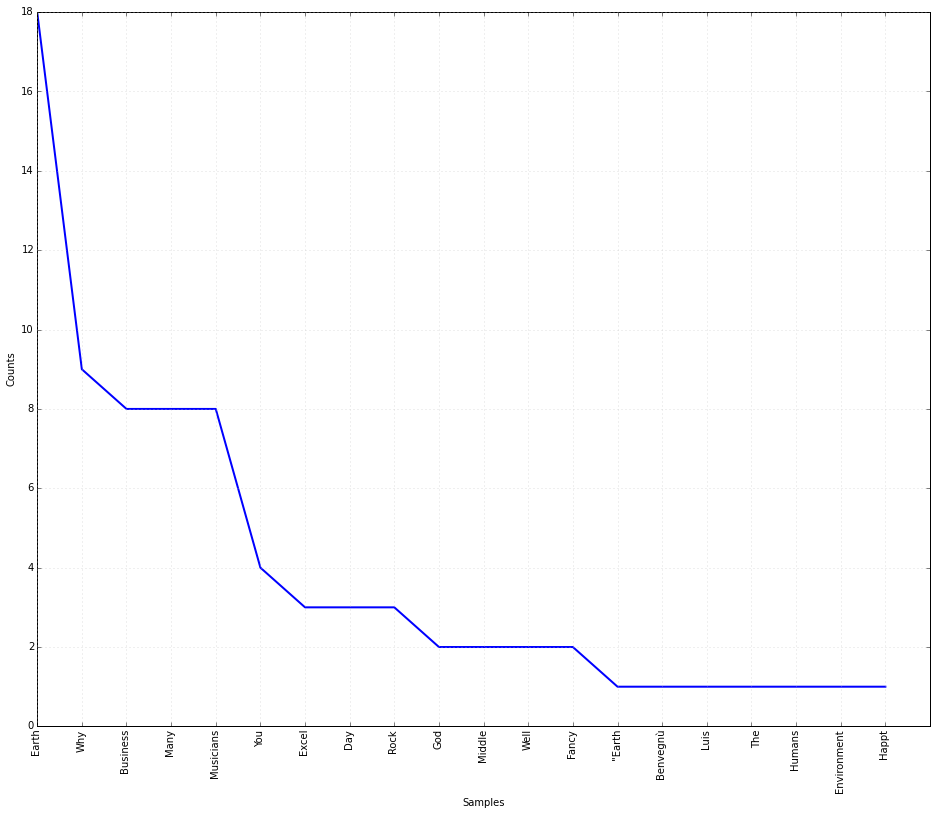

In [116]:
freq_names = nltk.FreqDist(names)
freq_names.plot(20)

#### Sentiment Analysis

In [117]:
badwords =   ['abandoned','abused','accused','addicted','afraid','aggravated',
              'aggressive','alone','angry','anguish','annoyed','anxious','apprehensive',
              'argumentative','artificial','ashamed','assaulted','at a loss','at risk',
              'atrocious','attacked','avoided','awful','awkward','bad','badgered','baffled',
              'banned','barren','beat','beaten down','belittled','berated','betrayed',
              'bitched at','bitter','bizzare','blacklisted','blackmailed','blamed','bleak',
              'blown away','blur','bored','boring','bossed-around','bothered','bothersome',
              'bounded','boxed-in','broken','bruised','brushed-off','bugged','bullied',
              'bummed','bummed out','burdened','burdensome','burned','burned-out',
              'caged in','careless','chaotic','chased','cheated','cheated on','chicken',
              'claustrophobic','clingy','closed','clueless','clumsy','coaxed',
              'codependent','coerced','cold','cold-hearted','combative','commanded',
              'compared','competitive','compulsive','conceited','concerned',
              'condescended to','confined','conflicted','confronted','confused',
              'conned','consumed','contemplative','contempt','contentious','controlled',
              'convicted','cornered','corralled','cowardly','crabby','cramped','cranky',
              'crap','crappy','crazy','creeped out','creepy','critical','criticized',
              'cross','crowded','cruddy','crummy','crushed','cut-down','cut-off','cynical',
              'damaged','damned','dangerous','dark','dazed','dead','deceived','deep',
              'defamed','defeated','defective','defenseless','defensive','defiant',
              'deficient','deflated','degraded','dehumanized','dejected','delicate',
              'deluded','demanding','demeaned','demented','demoralized','demotivated',
              'dependent','depleted','depraved','depressed','deprived','deserted',
              'deserving of pain/punishment','desolate','despair','despairing',
              'desperate','despicable','despised','destroyed','destructive',
              'detached','detest','detestable','detested','devalued','devastated',
              'deviant','devoid','diagnosed','dictated to','different','difficult',
              'directionless','dirty','disabled','disagreeable','disappointed',
              'disappointing','disapproved of','disbelieved','discardable','discarded',
              'disconnected','discontent','discouraged','discriminated','disdain',
              'disdainful','disempowered','disenchanted','disgraced','disgruntled',
              'disgust','disgusted','disheartened','dishonest','dishonorable',
              'disillusioned','dislike','disliked','dismal','dismayed','disorganized',
              'disoriented','disowned','displeased','disposable','disregarded',
              'disrespected','dissatisfied','distant','distracted','distraught',
              'distressed','disturbed','dizzy','dominated','doomed','double-crossed',
              'doubted','doubtful','down','down and out','down in the dumps',
              'downhearted','downtrodden','drained','dramatic','dread','dreadful',
              'dreary','dropped','drunk','dry','dumb','dumped','dumped on','duped',
              'edgy','egocentric','egotistic','egotistical','elusive','emancipated',
              'emasculated','embarrassed','emotional','emotionless','emotionally bankrupt',
              'empty','encumbered','endangered','enraged','enslaved','entangled','evaded',
              'evasive','evicted','excessive','excluded','exhausted','exploited','exposed',
              'fail','failful','fake','false','fear','fearful','fed up','flawed','forced',
              'forgetful','forgettable','forgotten','fragile','freaked out','frightened',
              'frigid','frustrated','furious','gloomy','glum','gothic','grey','grief','grim',
              'gross','grossed-out','grotesque','grouchy','grounded','grumpy','guilt-tripped',
              'guilty','harassed','hard','hard-hearted','harmed','hassled','hate','hateful',
              'hatred','haunted','heartbroken','heartless','heavy-hearted','helpless',
              'hesitant','hideous','hindered','hopeless','horrible','horrified','horror',
              'hostile','hot-tempered','humiliated','hung up','hung over','hurried','hurt',
              'hysterical','idiot','idiotic','ignorant','ignored','ill','ill-tempered',
              'imbalanced','imposed-upon','impotent','imprisoned','impulsive','in the dumps',
              'in the way','inactive','inadequate','incapable','incommunicative','incompetent',
              'incompatible','incomplete','incorrect','indecisive','indifferent',
              'indoctrinated','inebriated','ineffective','inefficient','inferior',
              'infuriated','inhibited','inhumane','injured','injusticed','insane',
              'insecure','insignificant','insincere','insufficient','insulted',
              'intense','interrogated','interrupted','intimidated','intoxicated',
              'invalidated','invisible','irrational','irritable','irritated',
              'isolated','jaded','jealous','jerked around','joyless','judged',
              'kept apart','kept away','kept in','kept out','kept quiet','labeled',
              'laughable','laughed at','lazy','leaned on','lectured to','left out',
              'let down','lied about','lied to','limited','little','lonely','lonesome',
              'longing','lost','lousy','loveless','low','mad','made fun of','man handled',
              'manipulated','masochistic','messed with','messed up','messy','miffed',
              'miserable','misled','mistaken','mistreated','mistrusted','misunderstood',
              'mixed-up','mocked','molested','moody','nagged','needy','negative',
              'nervous','neurotic','nonconforming','numb','nuts','nutty','objectified',
              'obligated','obsessed','obsessive','obstructed','odd','offended',
              'on display','opposed','oppressed','out of place','out of touch',
              'over-controlled','over-protected','overwhelmed','pain','panic','paranoid',
              'passive','pathetic','pessimistic','petrified','phony','picked on','pissed',
              'pissed off','plain','played with','pooped','poor','powerless','pre-judged',
              'preached to','preoccupied','predjudiced','pressured','prosecuted',
              'provoked','psychopathic','psychotic','pulled apart','pulled back',
              'punished','pushed','pushed away','put down','puzzled','quarrelsome',
              'queer','questioned','quiet','rage','raped','rattled','regret','rejected',
              'resented','resentful','responsible','retarded','revengeful','ridiculed',
              'ridiculous','robbed','rotten','sad','sadistic','sarcastic','scared',
              'scarred','screwed','screwed over','screwed up','self-centered','self-conscious',
              'self-destructive','self-hatred','selfish','sensitive','shouted at','shy',
              'singled-out','slow','small','smothered','snapped at','spiteful','stereotyped',
              'strange','stressed','stretched','stuck','stupid','submissive','suffering',
              'suffocated','suicidal','superficial','suppressed','suspicious','worse','worst'
              ,'bankrupcy','jobs','shit','socialism','#sob']

In [118]:
goodwords =  ['Abundant','Accomplished','Achieving','Active','Admirable','Adorable',
              'Adventurous','Admired','Affluent','Agreeable','Alert','Aligned','Alive',
              'Amazing','Appealing','Appreciate','Artistic','Astounding','Astute',
              'Attentive','Attractive','Auspicious','Authentic','Awake','Aware','Awesome',
              'Beaming','Beautiful','Better','Best','Blessed','Bliss','Bold','Bright','Brilliant',
              'Brisk','Buoyant','Calm','Capable','Centered','Certain','Charming',
              'Cheerful','Clear','Clever','Competent','Complete','Confident','Connected',
              'Conscious','Considerate','Convenient','Courageous','Creative','Daring',
              'Dazzling','Delicious','Delightful','Desirable','Determined','Diligent',
              'Discerning','Discover','Dynamic','Eager','Easy','Efficient','Effortless',
              'Elegant','Eloquent','Energetic','Endless','Enhancing','Engaging','Enormous'
              ,'Enterprising','Enthusiastic','Enticing','Excellent','Exceptional','Exciting'
              ,'Experienced','Exquisite','Fabulous','Fair','Far-Sighted','Fascinating',
              'Fine','Flattering','Flourishing','Fortunate','Free','Friendly','Fulfilled',
              'Fun','Generous','Genuine','Gifted','Glorious','Glowing','Good','Good-Looking',
              'Gorgeous','Graceful','Gracious','Grand','Great','Handsome','Happy','Hardy',
              'Harmonious','Healed','Healthy','Helpful','Honest','Humorous','Ideal',
              'Imaginative','Impressive','Industrious','Ingenious','Innovative','Inspired',
              'Intelligent','Interested','Interesting','Intuitive','Inventive','Invincible',
              'Inviting','Irresistible','Joyous','Judicious','Keen','Kind','Knowing','Leader',
              'Limitless','Lively','Loving','Lucky','Luminous','Magical','Magnificent',
              'Marvellous','Masterful','Mighty','Miraculous','Motivated','Natural','Neat',
              'Nice','Nurturing','Noble','Optimistic','Outstanding','Passionate','Peaceful',
              'Perfect','Persevering','Persistent','Playful','Pleasing','Plentiful','Positive',
              'Powerful','Precious','Prepared','Productive','Profound','Prompt','Prosperous',
              'Proud','Qualified','Quick','Radiant','Reasonable','Refined','Refreshing',
              'Relaxing','Reliable','Remarkable','Resolute','Resourceful','Respected',
              'Rewarding','Robust','Safe','Satisfied','Secure','Seductive','Self-Reliant',
              'Sensational','Sensible','Sensitive','Serene','Sharing','Skilful','Smart',
              'Smashing','Smooth','Sparkling','Spiritual','Splendid','Strong','Stunning',
              'Successful','Superb','Swift','Talented','Tenacious','Terrific','Thankful',
              'Thrilling','Thriving','Timely','Trusting','Truthful','Ultimate','Unique',
              'Valiant','Valuable','Versatile','Vibrant','Victorious','Vigorous','Vivacious',
              'Vivid','Warm','Wealthy','Well','Whole','Wise','Wonderful','Worthy','Young',
              'Youthful','Zeal','Zest']

In [119]:
def percentage(count, total):
    return 100 * count / float(total)

In [120]:
def sentiment_analysis(texto, goodwords, badwords):
    '''
    Not a sophisticated one, but the main idea is present.
    Please read: http://alias-i.com/lingpipe/demos/tutorial/sentiment/read-me.html
    '''
    goodness = 0
    badness = 0    
    for word in goodwords:
        goodness += percentage(texto.count(word.lower()), len(texto))
    for word in badwords:
        badness += percentage(texto.count(word.lower()), len(texto))
    if badness:
        ratio = goodness/float(badness)
    print(u'Grau de negatividade: {}'.format(badness))
    print(u'Grau de positividade: {}'.format(goodness))
    if badness:
        print(u'Razão: {}'.format(ratio))
    return goodness, badness

In [121]:
sentiment_analysis(tweets_words, goodwords, badwords);

Grau de negatividade: 0.892857142857
Grau de positividade: 0.637755102041
Razão: 0.714285714286


#### Geographic Analysis

https://pypi.python.org/pypi/basemap/1.0.7  
http://matplotlib.org/basemap/  
http://matplotlib.org/basemap/users/installing.html  
http://nbviewer.ipython.org/github/ehmatthes/intro_programming/blob/master/notebooks/visualization_earthquakes.ipynb  

In [122]:
#http://matplotlib.org/basemap/api/basemap_api.html
from mpl_toolkits.basemap import Basemap

In [152]:
msgpublicas = api.GetStreamSample()
geo_points = 0
lats, lons = [], []
users = []
while geo_points < 20:
    tweet = msgpublicas.next()
    if tweet.has_key('coordinates') and tweet['coordinates'] != None:
        coords = tweet['coordinates']['coordinates']
        user = tweet['user']['id']
        print(u'Usuário {} nas coordenadas {}'.format(user, [coords[1],coords[0]]))
        lons.append(float(coords[0]))
        lats.append(float(coords[1]))
        users.append(user)
        geo_points +=1

Usuário 2981503901 nas coordenadas [48.078101, -1.714642]
Usuário 2749217533 nas coordenadas [25.461638, 68.72067]
Usuário 3065323635 nas coordenadas [36.874384, 30.727493]
Usuário 3056100616 nas coordenadas [38.130911, 13.293444]
Usuário 1466027521 nas coordenadas [29.562756, -95.295386]
Usuário 1129228170 nas coordenadas [40.232113, 33.042033]
Usuário 2639428014 nas coordenadas [-38.731191, -62.292832]
Usuário 418853247 nas coordenadas [29.26135, 48.066069]
Usuário 314629422 nas coordenadas [38.400003, 26.98981]
Usuário 1607302489 nas coordenadas [52.695367, 5.18513]
Usuário 2970116956 nas coordenadas [-23.654425, -46.447525]
Usuário 1614268472 nas coordenadas [29.28819, 48.024323]
Usuário 887649678 nas coordenadas [-23.751501, -46.667282]
Usuário 1106516731 nas coordenadas [2.771881, 101.759843]
Usuário 2234886092 nas coordenadas [-33.755018, -61.953575]
Usuário 2305370347 nas coordenadas [53.445191, -2.932525]
Usuário 2455783144 nas coordenadas [-34.463791, -58.577754]
Usuário 1538

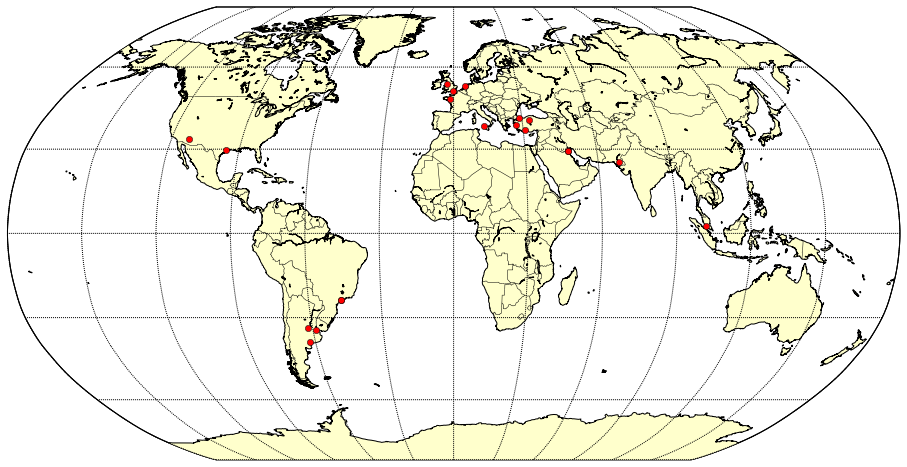

In [153]:
map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0, lat_0=0, lon_0=0)

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = '#FFFFCC') #http://www.w3schools.com/tags/ref_colorpicker.asp
map.drawmapboundary()
map.drawmeridians(np.arange(0, 360, 30))
map.drawparallels(np.arange(-90, 90, 30))

x,y = map(lons, lats)
map.plot(x, y, 'ro', markersize=6)
plt.show()

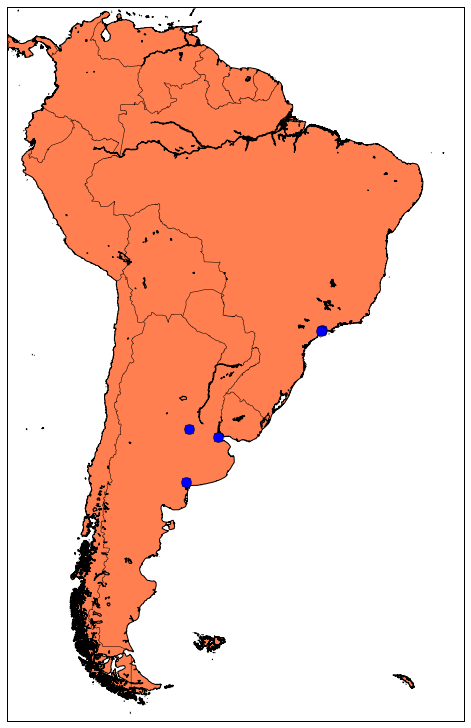

In [154]:
map = Basemap(projection='merc', lat_0 = -22, lon_0 = -56.5,resolution = 'h', area_thresh = 0.1, 
              llcrnrlon=-83.0, llcrnrlat=-57.0, urcrnrlon=-30.0, urcrnrlat=13.0)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()

x,y = map(lons, lats)
map.plot(x, y, 'bo', markersize=10)

plt.show()

Zoom em uma coordenada:

In [155]:
def gmap(lat,lon,zoom=10):
    # Google Maps URL template for an iframe
    google_maps_url = "http://maps.google.com/maps?q={0}+{1}&ie=UTF8&t=h&z={2}&{0},{1}&output=embed".format(lat,lon,zoom)
    display(IFrame(google_maps_url, '800px', '600px'))

In [156]:
gmap(lats[0],lons[0],4)

#### Graphs

In [129]:
def get_rt_origins(tweet):
    ''' Regex adapted from 
    http://stackoverflow.com/questions/655903/python-regular-expression-for-retweets'''
    rt_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
    rt_origins = []
    try:
        rt_origins += [mention.strip() for mention in rt_patterns.findall(tweet)[0][1].split()]
    except IndexError, e:
        pass
    return [rto.strip("@") for rto in rt_origins]

In [130]:
def create_graph_retweets(tweets):
    g = nx.DiGraph()
    for tweet in tweets:
        rt_origins = get_rt_origins(tweet.text)
        if not rt_origins:
            continue
        for rt_origin in rt_origins:
            g.add_edge(rt_origin, tweet.user.screen_name, {'tweet_id': tweet.id})
    return g

In [131]:
g_rt = create_graph_retweets(tweets)
print("Number of nodes is: {}\n".format(g_rt.number_of_nodes()))
print("Number of edges is: {}\n".format(g_rt.number_of_edges()))

Number of nodes is: 36

Number of edges is: 20



In [132]:
import operator
sorted_dic = sorted(g_rt.degree().items(), key=operator.itemgetter(1), reverse=True)
sorted_dic

[(u'mikesanz19', 3),
 (u'TalkTalk_UK', 2),
 (u'ADORABLE_EARTH', 2),
 (u'CHOCOOLIIE', 1),
 (u'jasmer_insan', 1),
 (u'AstroTerry', 1),
 (u'Murvish11', 1),
 (u'HEwokVoice', 1),
 (u'yukakoyamagishi', 1),
 (u'Magdalenalovisa', 1),
 (u'TheFunnyTeens', 1),
 (u'anamericangod', 1),
 (u'YouTube', 1),
 (u'AsteroidMisses', 1),
 (u'IKW_Official', 1),
 (u'dianemartin545', 1),
 (u'jonimettala', 1),
 (u'ohlordhes', 1),
 (u'SharoneDlamini', 1),
 (u'sumantapradha12', 1),
 (u'AgentDaeche', 1),
 (u'gooner_saad', 1),
 (u'rizwanimaan123', 1),
 (u'C_X_', 1),
 (u'ShahAfridi100', 1),
 (u'DannyBeegie', 1),
 (u'ST0NES', 1),
 (u'dwade575', 1),
 (u'Earth_Jeerakrit', 1),
 (u'penewax', 1),
 (u'ElfuzoSinZu', 1),
 (u'LXVINGMALIK', 1),
 (u'neuralwiles', 1),
 (u'_JakeGear', 1),
 (u'SonaMandeep', 1),
 (u'prayerbullets', 1)]

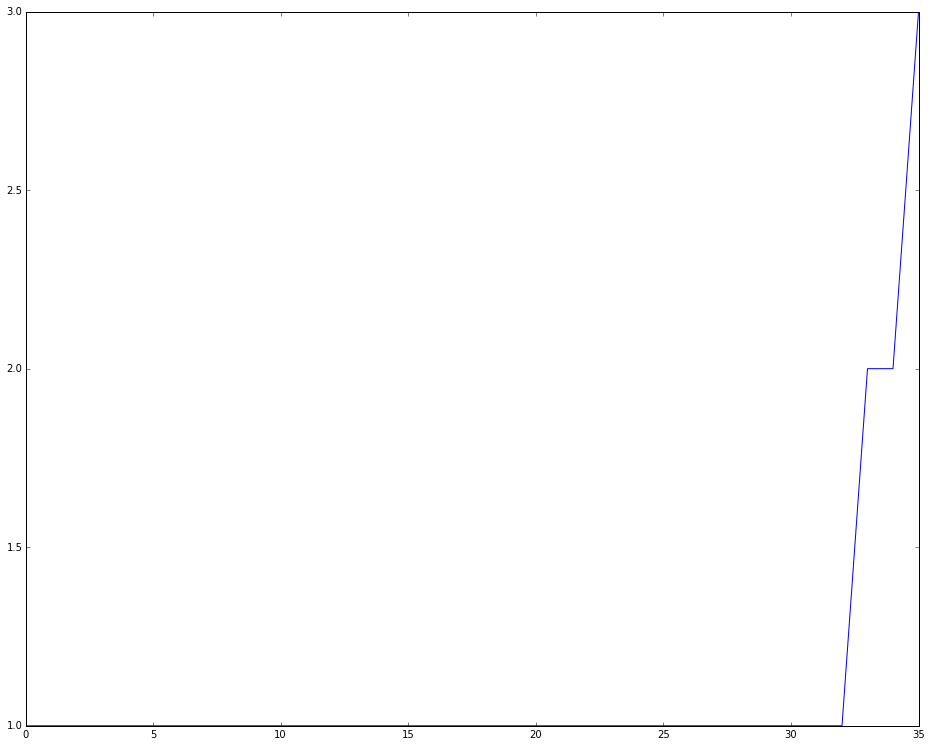

In [133]:
dic = nx.degree(g_rt)
plt.plot(sorted(dic.values()))

In [134]:
def save_dotfile(g):
    try:
        nx.drawing.write_dot(g, pathdotfile)
        print >> sys.stderr, 'Graph exported for file: {}'.format(pathdotfile)
    except (ImportError, UnicodeEncodeError): 
        # Este bloco serve para usuarios de windows, que certamente terao problemas
        # com o metodo nx.drawing.write_dot. Tambem serve para os casos em que temos
        # problemas com o unicode
        dot = [u'"{}" -> "{}" [tweet_id={}]'.format(n1, n2, g[n1][n2]['tweet_id']) for (n1, n2) in g.edges()]
        f = codecs.open(pathdotfile, 'w', encoding='utf-8')
        f.write('''strict digraph {{}}'''.format(';\n'.join(dot), ))
        f.close()
        print >> sys.stderr, 'Graph exported for file: {}'.format(pathdotfile)
        return f.name

In [135]:
save_dotfile(g_rt)

Graph exported for file: /home/rsouza/Dropbox/Renato/ModMinDados/outputs/graph_retweet.dot


Saving a dotfile

Obs: To generate a png graph from the dotfile, type in the Unix Prompt: 
'circo -Tpng -Gcharset=latin1 -Ograph_retweet graph_retweet.dot'

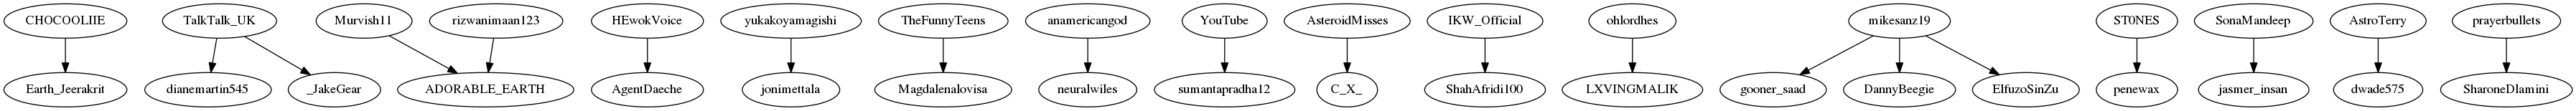

In [136]:
#Chamando um programa externo ao Ipython com o operador !
!dot -Tpng /home/rsouza/Dropbox/Renato/ModMinDados/outputs/graph_retweet.dot -o /home/rsouza/Dropbox/Renato/ModMinDados/outputs/graph_retweet.png
Image(pathpngfile)

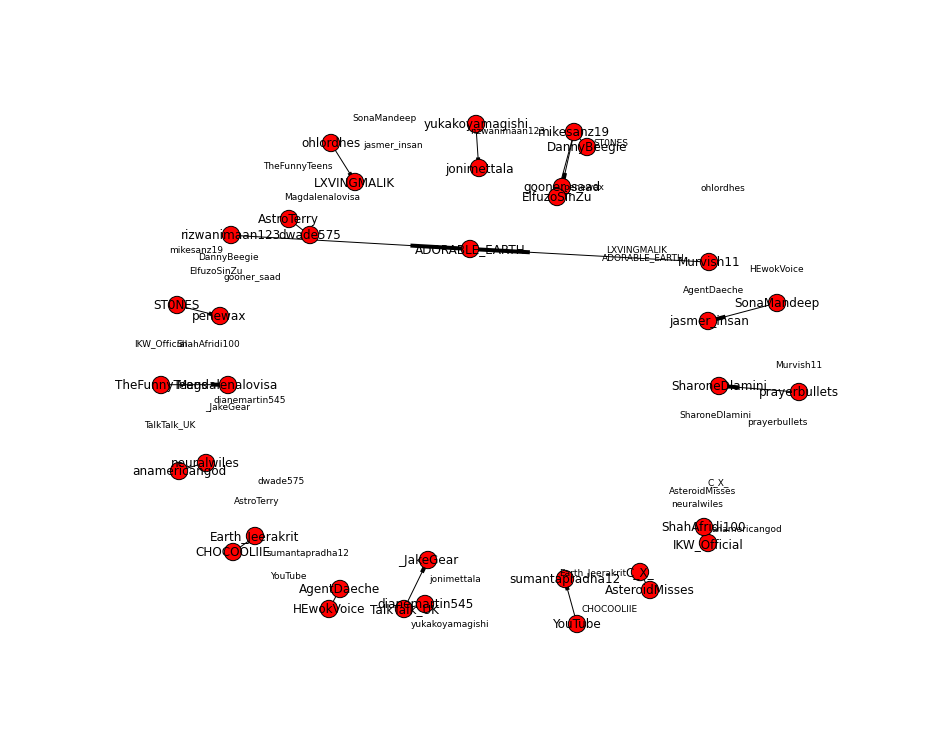

In [137]:
nx.draw_networkx_labels(g_rt,pos=nx.spring_layout(g_rt),font_size=9)
nx.draw(g_rt)
#nx.draw_random(g_rt)
#nx.draw_circular(g_rt)
#nx.draw_spectral(g_rt)

Saving a HTML file that uses javascript for visualizing the graph (needs a template)

In [138]:
def save_protovis_file(g):
    '''A visualization alternative is "protovis" javascript
    It uses the files "template_protoviz.html and "protovis-r3.2.js"
    '''
    nodes = g.nodes()
    indexed_nodes = {}
    idx = 0
    for n in nodes:
        indexed_nodes.update([(n, idx,)])
        idx += 1
    links = []
    for n1, n2 in g.edges():
        links.append({'source': indexed_nodes[n2],'target': indexed_nodes[n1]})
    json_data = json.dumps({"nodes" : [{"nodeName" : n} for n in nodes], "links" : links}, indent=4)
    html = open(pathtemplate).read().format(json_data,)
    f = open(pathprotofile, 'w')
    f.write(html)
    f.close()
    print >> sys.stderr, 'Graph exported for file: {}'.format(pathprotofile)
    return f.name, html

In [139]:
s = save_protovis_file(g_rt)

Graph exported for file: /home/rsouza/Dropbox/Renato/ModMinDados/outputs/graph_retweet.html


In [157]:
#!chromium /home/rsouza/Dropbox/Renato/ModMinDados/outputs/graph_retweet.html
webbrowser.open(os.path.join('file://', pathprotofile))

True

#### Visualizing with Ubigraph  

http://ubietylab.net/ubigraph/  
http://docs.python.org/library/xmlrpclib.html  
The package is quite old and is not being mantained. I left the code here just as an example for the brave!  

In [141]:
#import xmlrpclib
#import ubigraph
#ubiServer = "http://127.0.0.1:20738/RPC2"

In [142]:
def showing_in_ubigraph(graph, vstyles=[],estyles=[]):
    """
    Dynamic visualization using Ubigraph. Server should be
    running in the URL "ubiServer"
    graph.edges is a list of tuples: (n1,n2,w)
    """
    U = ubigraph.Ubigraph(URL=ubiServer)
    U.clear()
    nodes = {}
    edges = set([])
    #maxw = float(max(np.array([i[2] for i in graph.edges()]))) #largest weight
    if not vstyles:
        vstyles = cycle([U.newVertexStyle(id=1,shape="sphere", color="#ff0000")])
    else:
        vstyles = cycle(vstyles)
    rt_style = U.newVertexStyle(id=2,shape="sphere", color="#00ff00")
    for e in graph.edges():
        if e[0] not in nodes:
            n1 = U.newVertex(style=vstyles.next(), label=str(e[0]))#.decode('latin-1'))
            nodes[e[0]] = n1
        else:
            n1 = nodes[e[0]]
        if e[1] not in nodes:
            n2 = U.newVertex(style=rt_style, label=str(e[1]))
            nodes[e[1]] = n2
        else:
            n2 = nodes[e[1]]
        #es = e[2]/maxw
        if (n1,n2) not in edges:
            #U.newEdge(n1,n2,spline=True,strength=es, width=2.0, showstrain=True)
            U.newEdge(n1,n2,spline=True, width=2.0, showstrain=True)
            edges.add((n1,n2))
            edges.add((n2,n1))